![banner, Spotify Logo](https://djmag.com/sites/default/files/article/image/Header-1280x489%20%281%29_0.png)

# 🎶 Spotify Recommendation Playlist Based on the Emotion of Users Most Recently Played Songs - (DSI Capstone Project)
This project serves as the final capstone project for the MiSK Data Science immersive program.

## Background
This project aims to recommend songs to a user based on the mood of their most recently played songs on Spotify. There are two datasets that are obtained:
- **Spotify Mood Dataset**: contains around 2600 songs from 13 playlists from Spotify that are created by Spotify or other Spotify users. These playlists are created by mood. The moods that were obtained and will be observed are: Happy, Sad, Angry, Calm, and Energy. 
- **User Recently Played Dataset**: this dataset is obtained from the user and contains the 50 most recently played songs. To obtain this dataset, the user must give our app authorization. The installation and setting up of this is discussed [here](#usage).

To determine the mood of the song two variables for each track will be observed. The first is the valence of the track from the Spotify API audio features, the other is the lyrics of the track. These two variables are chosen specifically because choosing one or the other is usually not enough to determine the mood of the song, which can be considered specific to the user. Especially in cases where the lyrics of the song do not match the audio mood (valence) of the track. A popular example of a song like this is [Take a Walk by Passion Pit](https://www.youtube.com/watch?v=dZX6Q-Bj_xg), which is an upbeat happy sounding song with sad lyrics. On the flip side, a popular sad/mellow song that has hopeful/happy lyrics is [Don't Panic by Coldplay](https://www.youtube.com/watch?v=yWeuUwpEQfs).

### Spotify Audio Features:
Spotify uses a series of different features to classify tracks.
- **Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **Danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.
- **Loudness:** the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing the relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- **Speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- **Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, the tempo is the speed or pace of a given piece and derives directly from the average beat duration. [[1]](https://developer.spotify.com/discover/)[[2]](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)

### Lyrics:
Lyrics are not available on Spotify, so to obtain the lyrics of the tracks mutliple methods were used. 
- **Genius API**: Genius.com is one of the most popular and biggest collection of song lyrics and musical knowledge. They provide a [Genius API](https://docs.genius.com/) that makes utilizing their website much easier for developer. Additionally, using the [genius package](https://pypi.org/project/lyricsgenius/) (`lyricsgenius`) created for Python simplifies the process further by providing Python methods for the Genius API.
- **Web-scraping from Genius**: Similiary, Genius.com is web-scraped using the Python package [BeatifulSoup4](https://pypi.org/project/beautifulsoup4/). Web scraping is used first and if it's unsuccessful we resort to using the genius package, this is because the genius package runs very slowly. 
- **lyrics-extractor library**: For the Spotify mood playlist dataset, the [lyrics-extractor](https://pypi.org/project/lyrics-extractor/) library for Python is used, as it scrapes from AZLyrics, which is more lenient when it comes to being blocked while scraping. 


## Importing required libaries

In [750]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.impute import KNNImputer

from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


## Loading datasets

In [637]:
# Preparing Data
# Read csv of 50 most recently played songs of user
user_df = pd.read_csv('.\processed dataset\processed_user_dataset.csv')
# Read csv of spotify mood playlist dataset
spotify_df = pd.read_csv('.\processed dataset\processed_spotify_dataset.csv')

frames = [user_df,spotify_df]
# first 50 rows are the users recently played
df = pd.concat(frames)

In [638]:
df.shape

(2388, 19)

The dataset contains 12 columns that we can use for exploratory analysis. Since we have already cleaned the dataset, there is not alot of observed NaN values. Howeverm we will check to see:

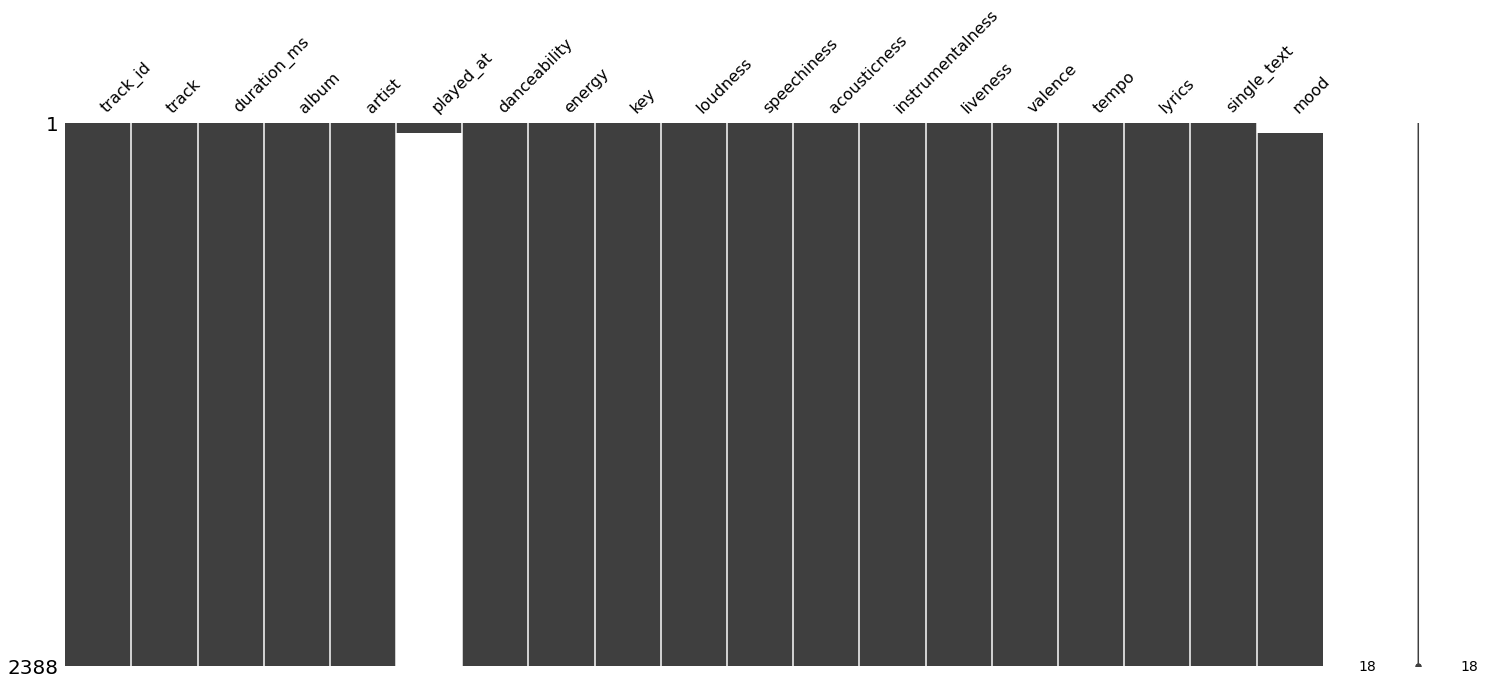

In [639]:
msno.matrix(df)
plt.show()

We can see that there are only two columns with missing values (noting that the first 50 rows are the users recently listened) played_at is null for the spotify dataset as it does not exist so we will keep the NaN values. On the other hand, the mood is null for the users songs, as this is information we currently don't have and will be predicting.

## Audio feature analysis

In [640]:
labels = list(df)[6:16]
features_df = df[['danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']]

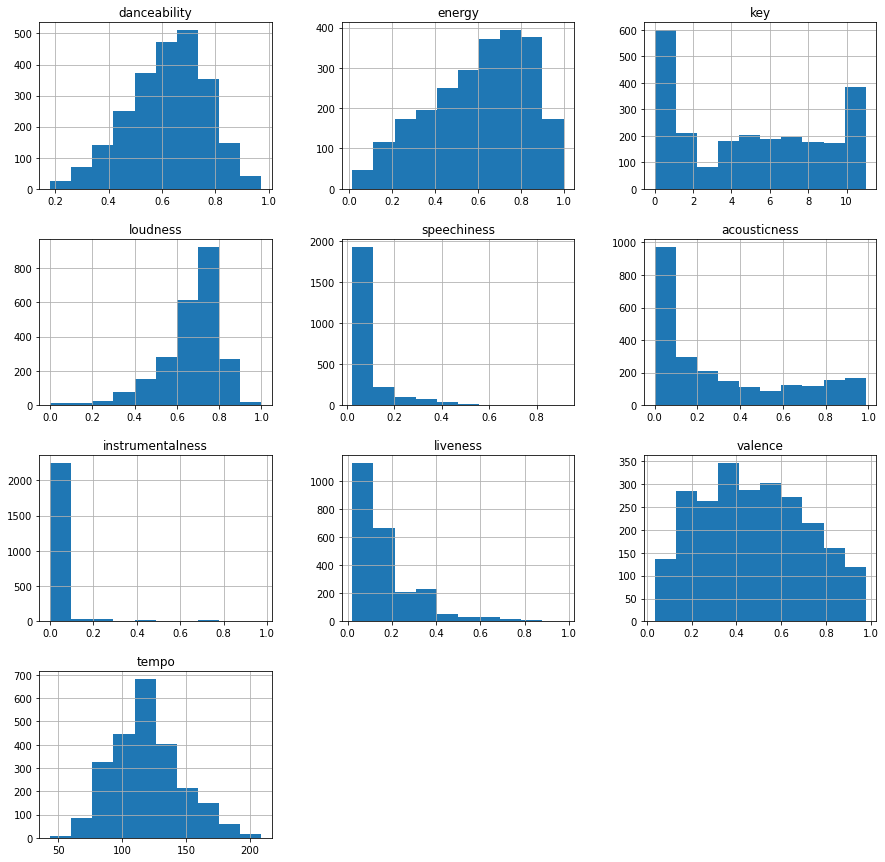

In [641]:
# showing distribution of each audio feature across all the observations
features_df.hist(figsize = (15,15))
plt.show()

By observing the histograms, we can see that the audio features that have the least variance between each observation are *speechiness* and *instrumentalness*. This tells us that the majority of our observations have around the same speechiness and instrumentalness, so these are features we probably won't be able to get alot of information out of. On the hand, *valence*, *tempo*, *energy*, and *danceability* have the most variance between each observation, so these are features that we should study to differentiate between the tracks and also find similiarities.

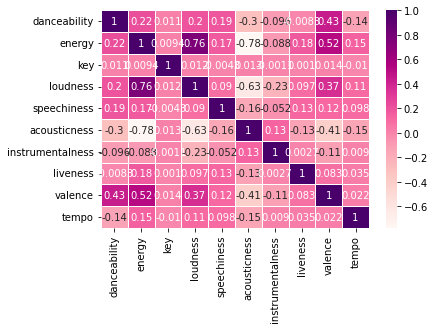

In [642]:
# Finding the correlation between all the audio features
scatter = sns.heatmap(features_df.corr(),  
annot=True,
linewidths=.5, cmap='RdPu')

We can see that there is the highest correlation between energy-loudness and valence-energy. While, we see there is an anti-correlation between acousticness-energy and acousticness-loudness. Both of these results are logical as energetic songs tend to be loud and have positive valence. While acoustic tracks are less likely to be loud and energetic.

In [643]:
pd.DataFrame(pd.DataFrame(df.groupby(df['artist']).
filter(lambda x: len(x)>10)).groupby("artist").energy.mean()).sort_values(by='energy',ascending=False)[:20]

,energy
artist,
City Morgue,0.849840
Katy Perry,0.782824
Lady Gaga,0.755636
Little Mix,0.750118
$uicideboy$,0.742516
Maroon 5,0.727786
One Direction,0.727706
Dua Lipa,0.722000
Shawn Mendes,0.695789


In [644]:
df.loc[df['artist'] == 'City Morgue', 'track']

12                       16 TOES
27              33rd Blakk Glass
36                       66SLAVS
57      ACAB (feat. Nascar Aloe)
59          ALL KILLER NO FILLER
140                        Arson
149     Aw Shit - Zillakami Solo
155                       BUAKAW
320                        CRANK
321                         CYKA
325                     Caligula
459                         DAWG
557                       Downer
794                  Gravehop187
803                HURTWORLD '99
1330                  NECK BRACE
1443             PROSTHETIC LEGS
1604                  SHINNERS13
1608                    SPLINTER
1710                    Sk8 Head
1731           Snow On Tha Bluff
1857                THE BALLOONS
1858     THE ELECTRIC EXPERIENCE
2046                         V12
2179                 YELLOW PISS
Name: track, dtype: object

If we disclude various artists, SuicideboyS is the most occuring artist in our dataset,
however, City Morgue has the most energetic songs and appears 25 times in our dataset

In [645]:
pd.DataFrame(pd.DataFrame(df.groupby(df['artist']).
filter(lambda x: len(x)>10)).groupby("artist").loudness.mean()).sort_values(by='loudness',ascending=False)[:20]

,loudness
artist,
Little Mix,0.783266
Katy Perry,0.780845
One Direction,0.768305
Dua Lipa,0.766334
Lady Gaga,0.763828
City Morgue,0.757022
$uicideboy$,0.741045
Shawn Mendes,0.736193
Maroon 5,0.732349


In [646]:
df.loc[df['artist'] == 'Little Mix', 'track']

63                            About the Boy
253                             Black Magic
626                                    F.U.
706                                   Freak
922     How Ya Doin'? (feat. Missy Elliott)
1038                    If You Want My Love
1071                            Joan of Arc
1218                    Love Me or Leave Me
1371                      No More Sad Songs
1387                                 Notice
1489                                  Power
1619                                 Salute
1689                     Shout Out to My Ex
1690                     Shout Out to My Ex
1845                           Sweet Melody
2084                                 Wasabi
2162      Woman Like Me (feat. Nicki Minaj)
Name: track, dtype: object

Even though we have a high correlation between loudness and energy, we can see that the artist with the loudest songs is Little Mix who appear in the dataset 17 times. If we observe our outputs we can also conclude that Katy Perry has the highest correlation between energy and loudness, appearing second in both.

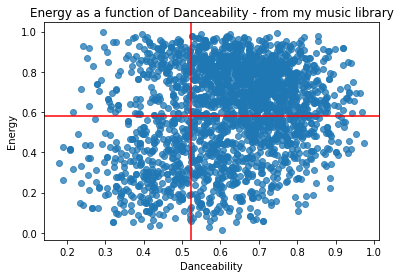

In [647]:
# 2-D scatter plot to visualize tendencies using some audio features, 
# specifically the "energy" and "danceability" features
# The red cross represents the "average popular song"'s audio features
average_noise = user_df['energy'].mean()
average_danceability = user_df['danceability'].mean()
plt.scatter(spotify_df['danceability'],spotify_df['energy'],alpha=0.75)
plt.axhline(y=average_noise, color='r')
plt.axvline(x=average_danceability, color='r')
plt.title("Energy as a function of Danceability - from my music library")
plt.xlabel("Danceability")
plt.ylabel("Energy")
plt.show()

Here we're comparing the users tendency to listen to songs that have energy and danceability compared to the Spotify dataset. We can see that the songs in the Spotify dataset generally have high energy and danceability. While the user (red cross) listens to songs that are nearly higher in energy than danceability. Generally, the Spotify dataset has a tracks with higher danceability and energy, while the user dataset has an almost intermediate level of energy and danceability.

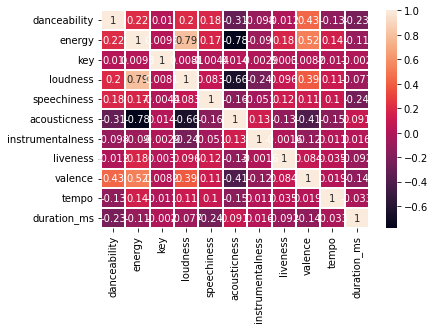

In [648]:
# Finding the correlation between all the audio features(continuous) and the mood(categorical)
enc = LabelEncoder()
spotify_df['mood_enc'] = enc.fit_transform(spotify_df['mood'])

corr = spotify_df.iloc[:, :-1].corr()
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            linewidths=.2,)
plt.show()

Noting that after encoding:
- 0 - Angry
- 1 - Calm
- 2 - Energy
- 3 - Happy
- 4 - Sad

True to our previous deduction, speechiness has the least correlation with the mood of a song. We can also note that not one audio feature has the highest correlation with the mood of a song. 


## NLP on lyrics

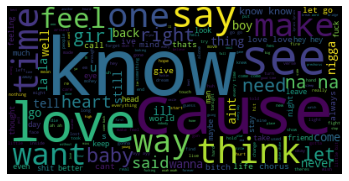

In [649]:
# Word cloud of user dataset lyrics vs. spotify dataset lyrics
wordcloud_spotify = WordCloud().generate(' '.join(spotify_df['single_text']))
plt.imshow(wordcloud_spotify)
plt.axis("off")
plt.show()

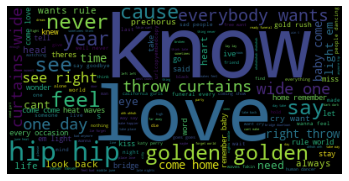

In [650]:
wordcloud_spotify = WordCloud().generate(' '.join(user_df['single_text']))
plt.imshow(wordcloud_spotify)
plt.axis("off")
plt.show()

Suprisingly, both datasets share the same most common words. This could indicate that the songs the user is listening to are very similiar to the collected data from Spotify. Another factor could be that these words are generally the most common. We can see from the following [article](https://visual.ly/community/Infographics/entertainment/top-30-most-common-words-found-1-million-songs) that most of the words generated in our wordcloud match.

It's hard to conclude the sentiment of the lyrics overall by looking at their  wordclouds. We will assign a sentiment to each song ranging from negative to neutral to positive. To do this we will perform sentiment analysis using popular lexicons.

These sentiments will help us identify the mood better:
- Positive: Energy and Happy (0.3 - 1.0)
- Neutral: Calm (-0.35 - 0.3)
- Negative: Sad and Angry (-1.0 - -0.35)

In [651]:
# NLP sentiment analysis using TextBlob
filter_values = [-1, -0.35, 0.3, 1]   

def sentiment_func(lyrics):
    try:
        return TextBlob(lyrics).sentiment
    except:
        return None

df['sentiment'] = df['single_text'].apply(sentiment_func)
df['sentiment'][0][0]
df['polarity'] = df['sentiment'].apply(lambda x: x[0])

df = df.drop(columns= 'sentiment')
df['sentiment'] = pd.cut(df['polarity'], bins=filter_values, 
                                     labels=['negative', 'neutral', 'positive'])

We won't be looking at subjectivity thats outputted with polarity under sentiment for TextBlob, as it's not relevant to song lyrics.

Polarity is a float that lies between [-1,1], -1 indicates negative sentiment and +1 indicates positive sentiments. However, by observing the results TextBlob does not always provide the expected results. So, we'll use VaderSentiment which gives a more detailed breakdown and compare the two.

In [652]:
# NLP sentiment analysis using Vader
analyzer = SentimentIntensityAnalyzer()
df['v_sentiment'] = df['single_text'].apply(analyzer.polarity_scores)
df = pd.concat([df.drop(['v_sentiment'], axis=1), df['v_sentiment'].apply(pd.Series)], axis=1)


df['v_sentiment'] = pd.cut(df['compound'], bins=filter_values, 
                                     labels=['negative', 'neutral', 'positive'])


Vader performs much better at predicting negative sentiment, however it also over exaggerates the neutrals and sometimes negatives to positive sentiments. After observing and comparing, we see that Vader is better at predicting Energy songs as positive and Angry songs as negatives, which are our extremes at both ends, but TextBlob is better at prediciting Calm songs as neutral. Both perform around the same for Happy and Sad Songs. However, if we take into consideration that the mood does not always match the sentiment of lyrics, we can conclude that that it can sometimes make sense for the mood not to match the sentiment. 

For example, Taylor Swifts 'Bad Blood' has a mood of Energy but the lyrics have a negative sentiment for both Vader and TextBlob and this can be because the lyrics contain words such as 'bad', 'sad', 'mad' etc. which are recognized as negative sentiment words.

In [653]:
# showing distribution of the classifications given by Vader and TextBlob
df.groupby(["mood", "sentiment", "v_sentiment"]).size().reset_index(name="count")


,mood,sentiment,v_sentiment,count
0,Angry,negative,negative,10
1,Angry,negative,neutral,0
2,Angry,negative,positive,2
3,Angry,neutral,negative,258
4,Angry,neutral,neutral,17
5,Angry,neutral,positive,143
6,Angry,positive,negative,3
7,Angry,positive,neutral,2
8,Angry,positive,positive,24
9,Calm,negative,negative,4


by observing and comparing the two lexicons, we can conclude that Vader performs better than TextBlob except in Calm songs, but thats because TextBlob tends to classify most of the songs as neutral, so it has a higher chance of classifying calm songs as neutral since most of its classifications are neutral.

In [654]:
# we will drop TextBlob and use Vader
df = df.drop(columns= ['sentiment','neg','pos','neu', 'polarity'])
df.rename(columns={'v_sentiment': 'sentiment', 'compound': 'polarity'}, inplace= True)

So we will be looking at both the valence of the song as well as its sentiment to recommend the songs to the user. Noting that valence is defined by spotify as a measure from 0.0 to 1.0 describing the musical positiveness  conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

So, by looking at both the audio feature and sentiment we can better determine the mood of the user's most recently listened to songs. Using our labelled data from the Spotify dataset, we can better predict the mood of the user's recently played songs.

## Predict value of moods for user
We will impute the NaN values in the mood column of the users dataset by comparing the audio feature values and sentiment of the track with those similiar to it that are already labelled in the spotify dataset. The reason we chose to use imputation instead of a machine learning algorithm, is that imputers have become powerful and  they are easier to use serving our function better.

In [655]:
# Encode mood column
df['mood_enc'] = df.mood.map({'Angry': 0, 'Sad': 1, 'Calm': 2, 'Happy': 3, 'Energy': 4})

The KNN imputer is a multi-variate imputer, which essentially means it can take multiple features when imputing the missing values. However, the imputer can only work on continuous variables, so we will first map our `mood` column to int values as an identifier for each mood. The idea in kNN methods is to identify ‘k’ samples in the dataset that are similar or close in the space. Then we use these ‘k’ samples to estimate the value of the missing data points. Each sample’s missing values are imputed using the mean value of the ‘k’-neighbors found in the dataset.[[1]](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/)

In [656]:
# knn based imputation for categorical variables
imputer = KNNImputer(n_neighbors= 2)
df_filled = imputer.fit_transform(df[['danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
'mood_enc']])
df_filled

array([[ 0.761 ,  0.525 , 11.    , ...,  0.0921,  0.531 ,  3.    ],
       [ 0.626 ,  0.528 ,  4.    , ...,  0.0995,  0.274 ,  1.    ],
       [ 0.559 ,  0.345 ,  4.    , ...,  0.141 ,  0.458 ,  2.5   ],
       ...,
       [ 0.561 ,  0.0848,  2.    , ...,  0.112 ,  0.206 ,  1.    ],
       [ 0.635 ,  0.673 ,  1.    , ...,  0.669 ,  0.837 ,  3.    ],
       [ 0.724 ,  0.895 ,  7.    , ...,  0.097 ,  0.64  ,  4.    ]])

We notice that some of the imputed values are floats between two integers. This means that the particular track belongs in more than mood. However, for our application we consider a track to only have one mood, so we will change the type of the result to int. Now, we will decode our mood and give them back their labels.

In [658]:
imputed_mood = df_filled[:,-1].astype(int)
imputed_mood[:50]
df = df.drop(columns='mood_enc')
df['mood_enc'] = imputed_mood.tolist()
df.reset_index(drop = True, inplace=True)
df['mood'] = df['mood_enc'].map({0: 'Angry', 1: 'Sad', 2: 'Calm', 3: 'Happy', 4: 'Energy'})

Just by observing the results, we can conclude that the imputer performed very well. Taking the song *Rhinestone Eyes by Gorillaz* as an example from the users dataset. The song has been identified to have positive lyrics (although I would personally categorize it as sentimentally negative) but the audio features ultimateley made the imputer decide to classify it under **Angry**, which is where I also would personally categorize this song too. 

## Recommending Songs to the User 
Now that we have labelled the 50 most recently listened to songs, we can observe what mood is the most occuring for the user and then recommend similiar songs that fall under that mood. We will be using Content-based filtering as this method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended. [[1]](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101)

In [755]:
df[:50]['artist'].value_counts()[:5]

Taylor Swift             4
Tears For Fears          3
Nothing But Thieves      2
Elbow                    2
Red Hot Chili Peppers    2
Name: artist, dtype: int64

In [797]:
df[:50]['track'].value_counts()[:5]

Everybody Wants To Rule The World    3
The Funeral                          2
gold rush                            2
Under the Bridge                     2
Chasing Cars                         2
Name: track, dtype: int64

In [661]:
df[:50]['mood'].value_counts()
# So our user is mainly listening to Sad and Calm songs

Sad       18
Calm      18
Happy     11
Energy     2
Angry      1
Name: mood, dtype: int64

How do we use a matrix for a recommendation? 
The answer is **similarity**. We now need to calculate the similarity of one lyric to another, as well as, one feature to another.
How do we do that?
We can use different metrics such as cosine similarity, or Euclidean distance. For our song recommendation system, we are going to use cosine similarity and particularly, its implementation from Scikit-learn.

In [870]:
features = ['instrumentalness','acousticness','danceability','energy','liveness','loudness','speechiness', 'tempo','valence','polarity']

def combine_all_features(row):
    return str(row['polarity']) +" "+ str(row['instrumentalness']) +" "+ str(row['acousticness']) +" "+ str(row['danceability'])+" "+ str(row["energy"])+" "+str(row["liveness"])+" "+str(row["loudness"])+" "+str(row["speechiness"])+" "+str(row["tempo"])+" "+str(row["valence"])

df['combined_features'] = df.apply(combine_all_features,axis=1)

cv = CountVectorizer()
count_matrix = cv.fit_transform(df['combined_features'])
cosine_sim = cosine_similarity(count_matrix)

def fetch_artist_from_index_1(index):
    return df[df.index == index]["artist"].values[0]

def fetch_index_from_artist_1(artist):
    return df[df.artist == artist].index.values[0]

user_choice_for_singer = "Taylor Swift"
artist_index = fetch_index_from_artist_1(user_choice_for_singer)

similar_artists =  list(enumerate(cosine_sim[artist_index]))

sim_artist_sort = sorted(similar_artists,key=lambda x:x[1],reverse=True)[2:]

i=0
print("Top 10 similar artists/singers to "+ user_choice_for_singer +" are:\n")
for element in sim_artist_sort:
    print(i+1,'->',fetch_artist_from_index_1(element[0]))
    print(f"    Similiarity score: %.4f" % sim_artist_sort[i][1])
    i=i+1
    if i>=10:
        break

Top 10 similar artists/singers to Taylor Swift are:

1 -> Leona Lewis
    Similiarity score: 0.1818
2 -> Donovan Woods
    Similiarity score: 0.1818
3 -> James Newton Howard
    Similiarity score: 0.1818
4 -> Leon Bridges
    Similiarity score: 0.1741
5 -> Stealth
    Similiarity score: 0.1741
6 -> Billie Eilish
    Similiarity score: 0.1741
7 -> Carly Rae Jepsen
    Similiarity score: 0.1741
8 -> OMI
    Similiarity score: 0.1741
9 -> Leon Bridges
    Similiarity score: 0.1741
10 -> Sticky Fingers
    Similiarity score: 0.1741


In [872]:
features = ['instrumentalness','acousticness','danceability','energy','liveness','loudness','speechiness', 'tempo','valence','polarity']

def combine_all_features(row):
    return str(row['polarity']) +" "+ str(row['instrumentalness']) +" "+ str(row['acousticness']) +" "+ str(row['danceability'])+" "+ str(row["energy"])+" "+str(row["liveness"])+" "+str(row["loudness"])+" "+str(row["speechiness"])+" "+str(row["tempo"])+" "+str(row["valence"])

df['combined_features'] = df.apply(combine_all_features,axis=1)

# Initialize tfidf vectorizer
tfidf = TfidfVectorizer(analyzer='word', stop_words='english')

# Fit and transform 
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
cosine_sim = cosine_similarity(tfidf_matrix)

# cv = CountVectorizer()
# count_matrix = cv.fit_transform(df['combined_features'])
# cosine_sim = cosine_similarity(count_matrix)

def fetch_song_from_index_2(index):
    return df[df.index == index]["track"].values[0]

def fetch_artist_from_index_2(index):
    return df[df.index == index]["artist"].values[0]

def fetch_index_from_song_2(track):
    return df[df.track == track].index.values[0]

user_choice_song = "Like I Did"
song_index = fetch_index_from_song_2(user_choice_song)

similar_songs =  list(enumerate(cosine_sim[song_index]))

similar_songs_sorted = sorted(similar_songs,key=lambda x:x[1],reverse=True)[4:]

i=0
print("Top 10 similar songs to "+ user_choice_song +" are:\n")
for element in similar_songs_sorted:
    print(i+1,'->',fetch_song_from_index_2(element[0])+" By "+ fetch_artist_from_index_2(element[0]))
    print("     Similiarity score:  %.4f" % similar_songs_sorted[i][1])
    i=i+1
    if i>=10:
        break

Top 10 similar songs to Like I Did are:

1 -> Ain't No Mountain High Enough - Stereo Version By Marvin Gaye
     Similiarity score:  0.1315
2 -> Overpass Graffiti By Ed Sheeran
     Similiarity score:  0.1305
3 -> Superhero By Hayd
     Similiarity score:  0.1285
4 -> One Day By Tate McRae
     Similiarity score:  0.1258
5 -> Gimme! Gimme! Gimme! (A Man After Midnight) By ABBA
     Similiarity score:  0.1244
6 -> Feeling Whitney By Post Malone
     Similiarity score:  0.1234
7 -> Hold Me While You Wait By Lewis Capaldi
     Similiarity score:  0.1221
8 -> Falling Up By Dean Lewis
     Similiarity score:  0.1177
9 -> Bad Romance By Lady Gaga
     Similiarity score:  0.1153
10 -> Gotta Be A Reason By Alec Benjamin
     Similiarity score:  0.1097


In [873]:
features = ['instrumentalness','acousticness','danceability','energy','liveness','loudness','speechiness', 'tempo','valence']

def combine_all_features(row):
    return str(row['instrumentalness']) +" "+ str(row['acousticness']) +" "+ str(row['danceability'])+" "+ str(row["energy"])+" "+str(row["liveness"])+" "+str(row["loudness"])+" "+str(row["speechiness"])+" "+str(row["tempo"])+" "+str(row["valence"])

df['combined_features'] = df.apply(combine_all_features,axis=1)

# Initialize tfidf vectorizer
tfidf = TfidfVectorizer(analyzer='word', stop_words='english')

# Fit and transform 
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
cosine_sim = cosine_similarity(tfidf_matrix)

# cv = CountVectorizer()
# count_matrix = cv.fit_transform(df['combined_features'])
# cosine_sim = cosine_similarity(count_matrix)

def fetch_song_from_index(index):
    return df[df.index == index]["track"].values[0]

def fetch_artist_from_index(index):
    return df[df.index == index]["artist"].values[0]

def fetch_index_from_mood(mood):
    return df[df.mood == mood].index.values[0]

user_choice_mood = "Sad"

song_index = fetch_index_from_mood(user_choice_mood)

similar_songs =  list(enumerate(cosine_sim[song_index]))

similar_songs_sorted = sorted(similar_songs,key=lambda x: x[1],reverse=True)[1:]

i=0
print("Top 10 similar songs that match the "+ user_choice_mood +" mood of your songs:\n")
for element in similar_songs_sorted:
    print(i+1,'->',fetch_song_from_index(element[0])+" By "+ fetch_artist_from_index(element[0]))
    print("     Similiarity score: %.4f" % similar_songs_sorted[i][1])
    i=i+1
    if i>=10:
        break

Top 10 similar songs that match the Sad mood of your songs:

1 -> Like I Did By JC Stewart
     Similiarity score: 1.0000
2 -> Moral of the Story By Ashe
     Similiarity score: 0.1860
3 -> Neva Cared By Polo G
     Similiarity score: 0.1787
4 -> Superhero By Hayd
     Similiarity score: 0.1461
5 -> Overpass Graffiti By Ed Sheeran
     Similiarity score: 0.1444
6 -> Ain't No Mountain High Enough - Stereo Version By Marvin Gaye
     Similiarity score: 0.1443
7 -> One Day By Tate McRae
     Similiarity score: 0.1424
8 -> Feeling Whitney By Post Malone
     Similiarity score: 0.1374
9 -> Gimme! Gimme! Gimme! (A Man After Midnight) By ABBA
     Similiarity score: 0.1370
10 -> Falling Up By Dean Lewis
     Similiarity score: 0.1332


The recommendations made for each given user input are accurate, besides a few tracks that do not match the criterias. However, generally, the model can recommend songs depending on the mood of the users most recently listened to artist,track, or general mood of all the recently played songs.

## Conclusion
